<a href="https://colab.research.google.com/github/TAMIDSpiyalong/ECEN-689/blob/main/Day2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Transfer Learning



Transfer learning is a machine learning technique where a model trained on one task or domain is reused and adapted to another related task or domain. Instead of starting the training of a new model from scratch, transfer learning leverages the knowledge learned from a source task to improve the learning of a target task. This approach is particularly useful when the target task has limited labeled data or when training a model from scratch on the target task is computationally expensive.

## Objectives

1. Use the PyTorch to load the dataset and test the pre-trained ResNet model
2. Use transfer learning to train a model to classify different dog breeds
3. Compare transfer learning and training from strach

## Pre-trained model and weights

In the context of deep learning, pre-trained weights are commonly used in transfer learning. During transfer learning, a pre-trained model, which has learned representations from a source task or dataset, is adapted to a different target task or dataset. By leveraging these pre-trained weights, the model starts with learned features that are useful for various computer vision tasks, such as image classification, object detection, or segmentation.

Typically, pre-trained weights are obtained from models trained on large-scale datasets, such as ImageNet, which contains millions of labeled images belonging to thousands of different categories. Models like VGG, ResNet, Inception, and others have been trained on ImageNet and have learned to recognize a wide range of visual features.

In this lab we swtich to PyTorch becuase the smallest ResNet18 is not available on Keras. To save training time, especially on Google colab, a small model size is necessary.

In [32]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import seaborn as sn
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

In [33]:
# Some images are not stardard giving warnings, which is too much information.
import warnings
warnings.filterwarnings("ignore")

We need to install some package to visualize Pytorch models. This is not as nice as Keras.

In [ ]:
! pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=50207347e5737466f770a65a35e5717e659997eb1091e6c834a316c3f42e98df
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=False)

# Display the model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Use a sample input tensor to create the computation graph
sample_input = torch.randn((1, 3, 224, 224)).to(device)
dot = make_dot(resnet50(sample_input), params=dict(resnet50.named_parameters()))

# Save the computation graph to a file (optional)
dot.format = 'png'
dot.render("resnet18_computation_graph")


ModuleNotFoundError: ignored

You can find the ResNet visualization `png` in our folder. Pay attention to the residual blocks that is the core innovation of ResNet, which is the use of skip connections or residual blocks. These connections allow information to skip one or more layers, making it easier to train deep networks. This helps in mitigating the vanishing gradient problem and accelerates the convergence of the training process.

In [34]:
# we do not have gpu on colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Download example data

This is the dataset we prepared for you. All the images are seperated by folder names.

In [52]:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1syxo1QtezuTnQsklIEj0OougzkZwRMse')


Downloading...
From: https://drive.google.com/uc?export=download&id=1cWggDLdX6ho9HejHH8t3MS5lt6wCjD5l
To: /content/Dog_Breeds.zip
100%|██████████| 650M/650M [00:08<00:00, 74.6MB/s]


'Dog_Breeds.zip'

In [ ]:
# https://drive.google.com/file/d/1cWggDLdX6ho9HejHH8t3MS5lt6wCjD5l/view?usp=drive_link
# https://drive.google.com/file/d/1syxo1QtezuTnQsklIEj0OougzkZwRMse/view?usp=drive_link

In [53]:
! unzip  Dog_Breed_Data.zip

Archive:  Dog_Breed_Data.zip
replace Dog_Breed_Data/Beagle/1.file_23012_beagle.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load and Split Image Data

The DataLoader is an essential component in deep learning frameworks, such as PyTorch and TensorFlow, that facilitates the efficient and convenient loading of data during training and evaluation. It provides an interface to handle data loading and batching, which is crucial for large datasets and complex models.

Define datatransform and augmentation

In [55]:
# this is the mean and standard deviation for imagenet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

torchvision.datasets.ImageFolder is a PyTorch dataset class provided by the torchvision library, specifically designed to work with image data stored in a structured folder format. It simplifies the process of loading image datasets for training and evaluation when the data is organized into separate folders, each representing a class, and containing images belonging to that class.

In this example, ImageFolder automatically reads the images and assigns labels based on the subfolder structure. The transform variable defines the preprocessing transformations applied to each image before it is used in the model.

ImageFolder is a convenient but rather simple. In our more advanced object detection and segmentation tasks, we need to define our custom dataset to load images and annotation.


In [56]:
images = datasets.ImageFolder('Dog_Breed_Data',transform)

This is an object with all necessary information to load the data. The data is not loaded at this step.

In [68]:
images.imgs[:5]

[('Dog_Breed_Data/Beagle/1.file_23012_beagle.jpg', 0),
 ('Dog_Breed_Data/Beagle/10.beagle_upsy.jpg', 0),
 ('Dog_Breed_Data/Beagle/10.canine.png', 0),
 ('Dog_Breed_Data/Beagle/11.500x500-07_beagle-1523993536226.png', 0),
 ('Dog_Breed_Data/Beagle/11.beagle-standing-in-a-frosty-field-on-a-cold-morning.jpg',
  0)]

In [59]:
data_size = len(images.imgs)
train_size = int(data_size*0.8)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = data.random_split(images, (train_size,val_size,test_size))


In [60]:
data_size,test_size,val_size

(246, 25, 25)

In [100]:
test_set

DataLoader in PyTorch is a utility class that facilitates efficient data loading and iteration during training or evaluation. It works in conjunction with custom datasets or built-in datasets like ImageFolder, automatically batching the data, shuffling it randomly to introduce diversity during training, and enabling parallel data loading with multiple worker processes to speed up the process. This class plays a crucial role in optimizing training performance and handling large datasets, ensuring that deep learning models can efficiently process data in batches, leading to faster and more effective model training.

In [62]:
from torch.utils.data import DataLoader

batch_size=4
class_names = images.classes

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)


As what we did in previous labs, we visualize the input examples and print the corresponding labels. In this case the total lenth of the classes is the amount of dog breeds.

torch.Size([224, 224])
tensor([4, 2, 0, 5])


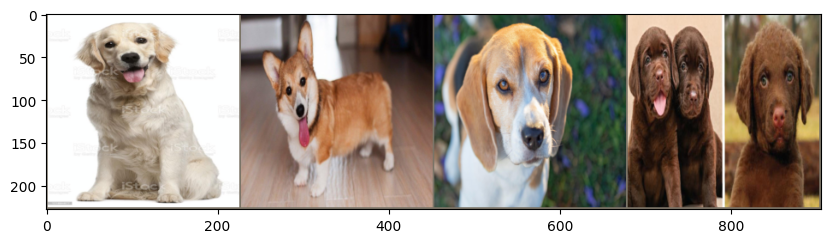

In [63]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean # correct the nornalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
print(inputs[0][0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10,5))
imshow(out, title='Input Examples')
print(classes)

## Train a Model Pre-trained Weights

In [98]:
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [99]:
since = time.time()

best_acc = 0.0
num_epochs=5

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)
    scheduler.step()

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


Epoch 0/9
----------
Epoch 1/10, Training Loss: 1.9455, Training Accuracy: 0.24%
Epoch 1/10, Validation Loss: 1.9517, validation Accuracy: 0.00%
Epoch 1/9
----------
Epoch 2/10, Training Loss: 1.9477, Training Accuracy: 0.26%
Epoch 2/10, Validation Loss: 1.9513, validation Accuracy: 0.24%
Epoch 2/9
----------
Epoch 3/10, Training Loss: 1.8903, Training Accuracy: 0.26%
Epoch 3/10, Validation Loss: 1.4603, validation Accuracy: 0.48%
Epoch 3/9
----------
Epoch 4/10, Training Loss: 1.8584, Training Accuracy: 0.28%
Epoch 4/10, Validation Loss: 1.4652, validation Accuracy: 0.52%
Epoch 4/9
----------
Epoch 5/10, Training Loss: 1.8506, Training Accuracy: 0.32%
Epoch 5/10, Validation Loss: 2.1112, validation Accuracy: 0.16%
Epoch 5/9
----------
Epoch 6/10, Training Loss: 1.6514, Training Accuracy: 0.37%
Epoch 6/10, Validation Loss: 1.5154, validation Accuracy: 0.56%
Epoch 6/9
----------
Epoch 7/10, Training Loss: 1.5419, Training Accuracy: 0.43%
Epoch 7/10, Validation Loss: 1.4676, validation A

For each batch every epoch, the some input and labels are loaded to calculated the loss. The optimizer then updates the weights using the partial derivitives. Pay attention to the green arrow on the left and you will see which part of the code is been excuted. The comments are also helpful to find the processes of each code.

Without loading the pretrained weight, the model optimizes to some degree of success but does not work very good.

Looking back, you can study what is the input and label in each batch when looping through the dataloader.

In [104]:
for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

print(inputs.size(),labels.size())

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [113]:
def visualize_model(model, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20))
    sm = torch.nn.Softmax()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            l=labels
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.set_xlabel('Groun Truth: {}'.format(class_names[l[j]]))
                ax.set_ylabel('Prediction: {}'.format(class_names[preds[j]]))
                ax.set_title('Confidence {:.2f}'.format(confidence[j]))

                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)
                if images_so_far == num_images:
                    return


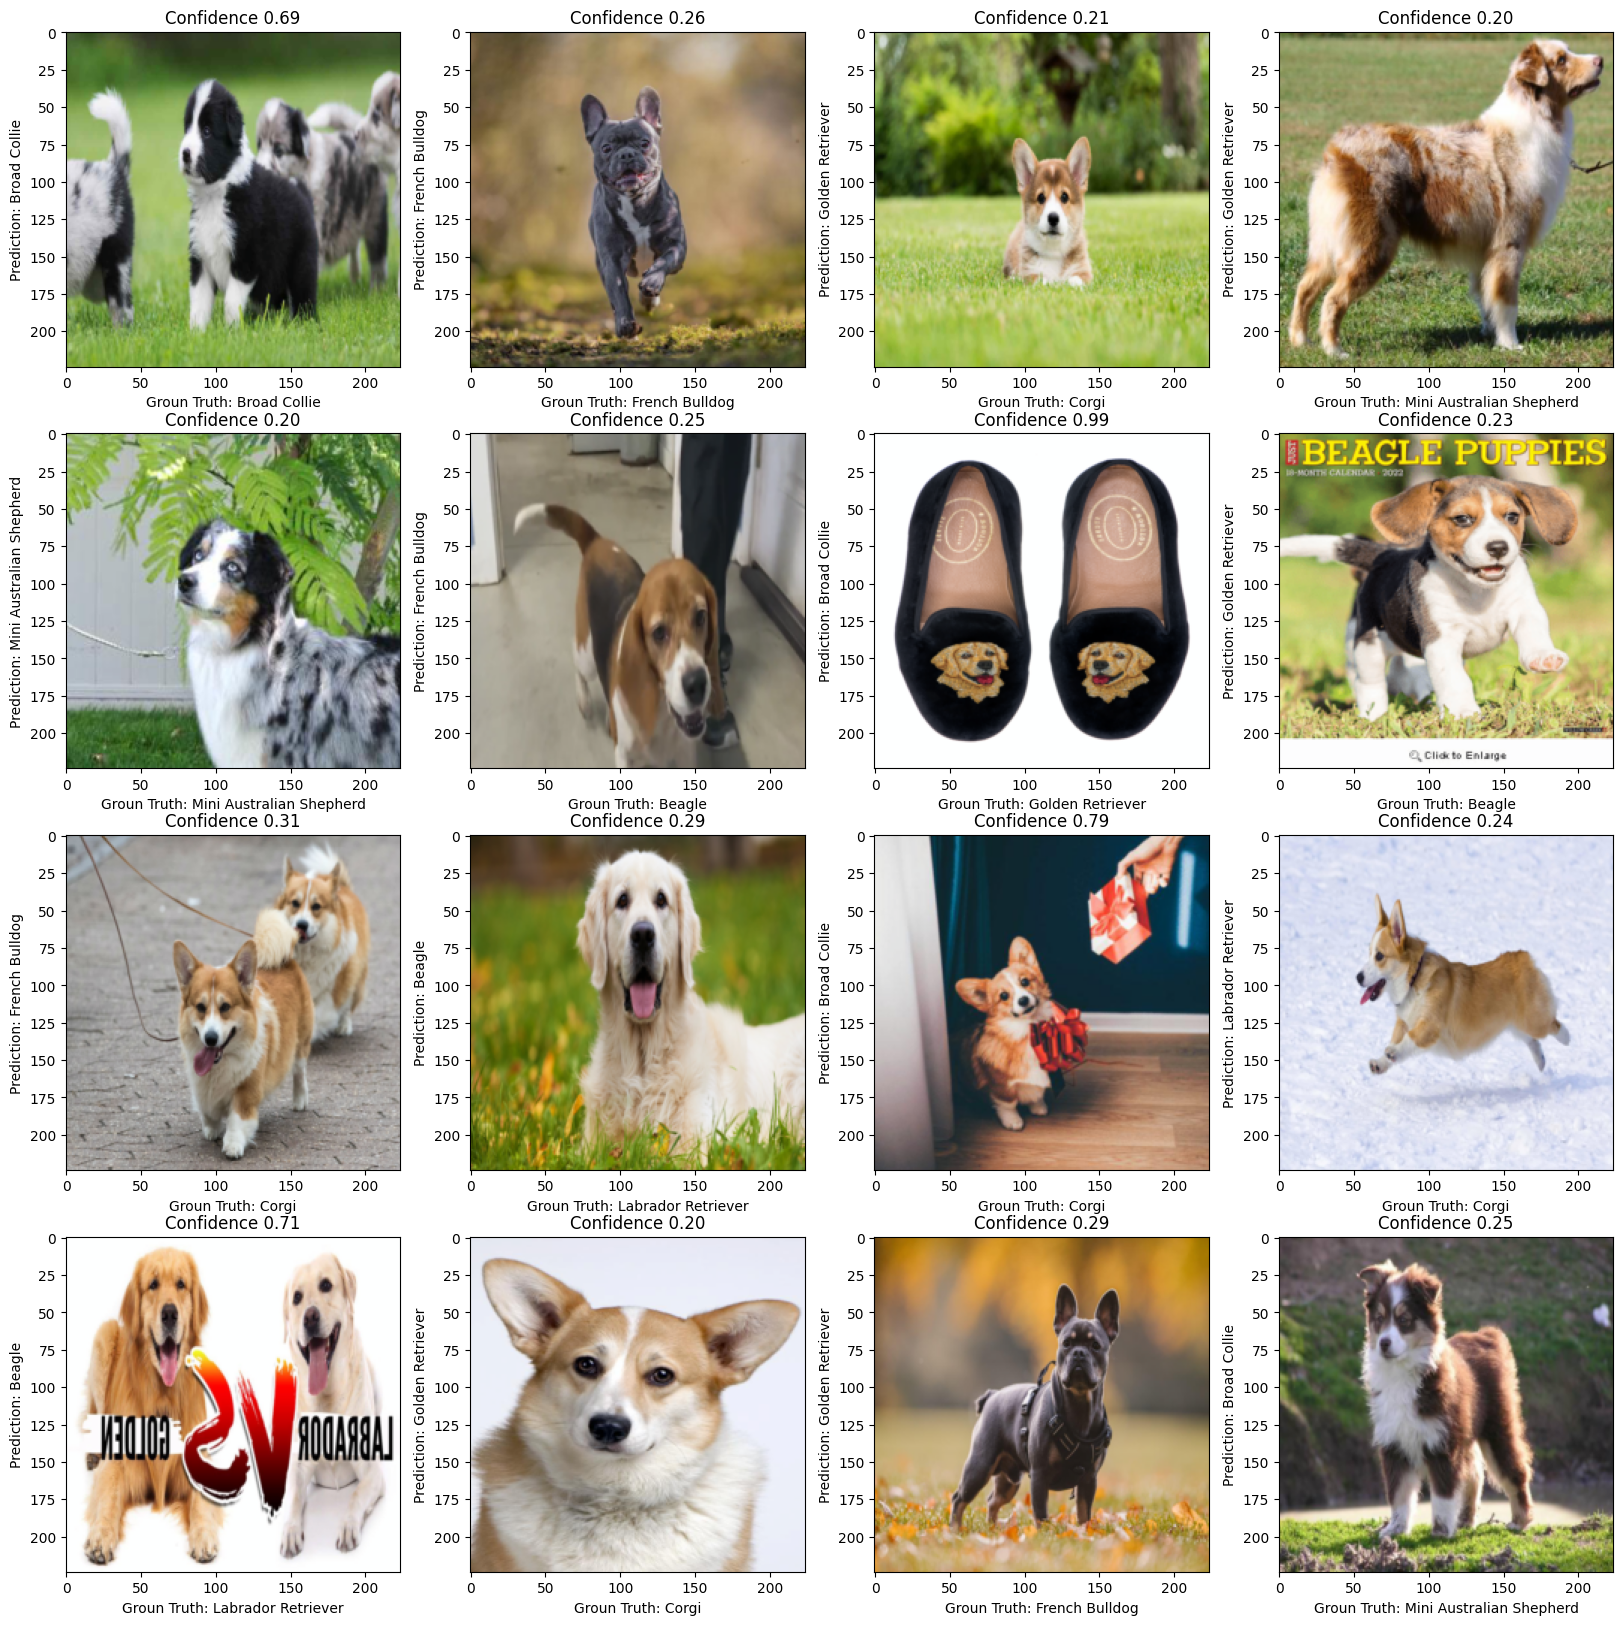

In [114]:
visualize_model(model)

## Train model using the pretrained weights

This time we load the pretrained weight and see the difference. Everything else remains the same.

In [116]:
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Train model

In [117]:
since = time.time()

best_acc = 0.0
num_epochs=5

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)
    scheduler.step()

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


Epoch 0/9
----------
Epoch 1/10, Training Loss: 1.5728, Training Accuracy: 0.44%
Epoch 1/10, Validation Loss: 0.2095, validation Accuracy: 0.92%
Epoch 1/9
----------
Epoch 2/10, Training Loss: 0.7476, Training Accuracy: 0.73%
Epoch 2/10, Validation Loss: 0.2808, validation Accuracy: 0.96%
Epoch 2/9
----------
Epoch 3/10, Training Loss: 0.4593, Training Accuracy: 0.86%
Epoch 3/10, Validation Loss: 0.1452, validation Accuracy: 0.96%
Epoch 3/9
----------
Epoch 4/10, Training Loss: 0.3400, Training Accuracy: 0.90%
Epoch 4/10, Validation Loss: 0.1034, validation Accuracy: 0.96%
Epoch 4/9
----------
Epoch 5/10, Training Loss: 0.3330, Training Accuracy: 0.84%
Epoch 5/10, Validation Loss: 0.2229, validation Accuracy: 0.92%
Epoch 5/9
----------
Epoch 6/10, Training Loss: 0.3099, Training Accuracy: 0.90%
Epoch 6/10, Validation Loss: 0.1090, validation Accuracy: 0.96%
Epoch 6/9
----------
Epoch 7/10, Training Loss: 0.1877, Training Accuracy: 0.95%
Epoch 7/10, Validation Loss: 0.1033, validation A

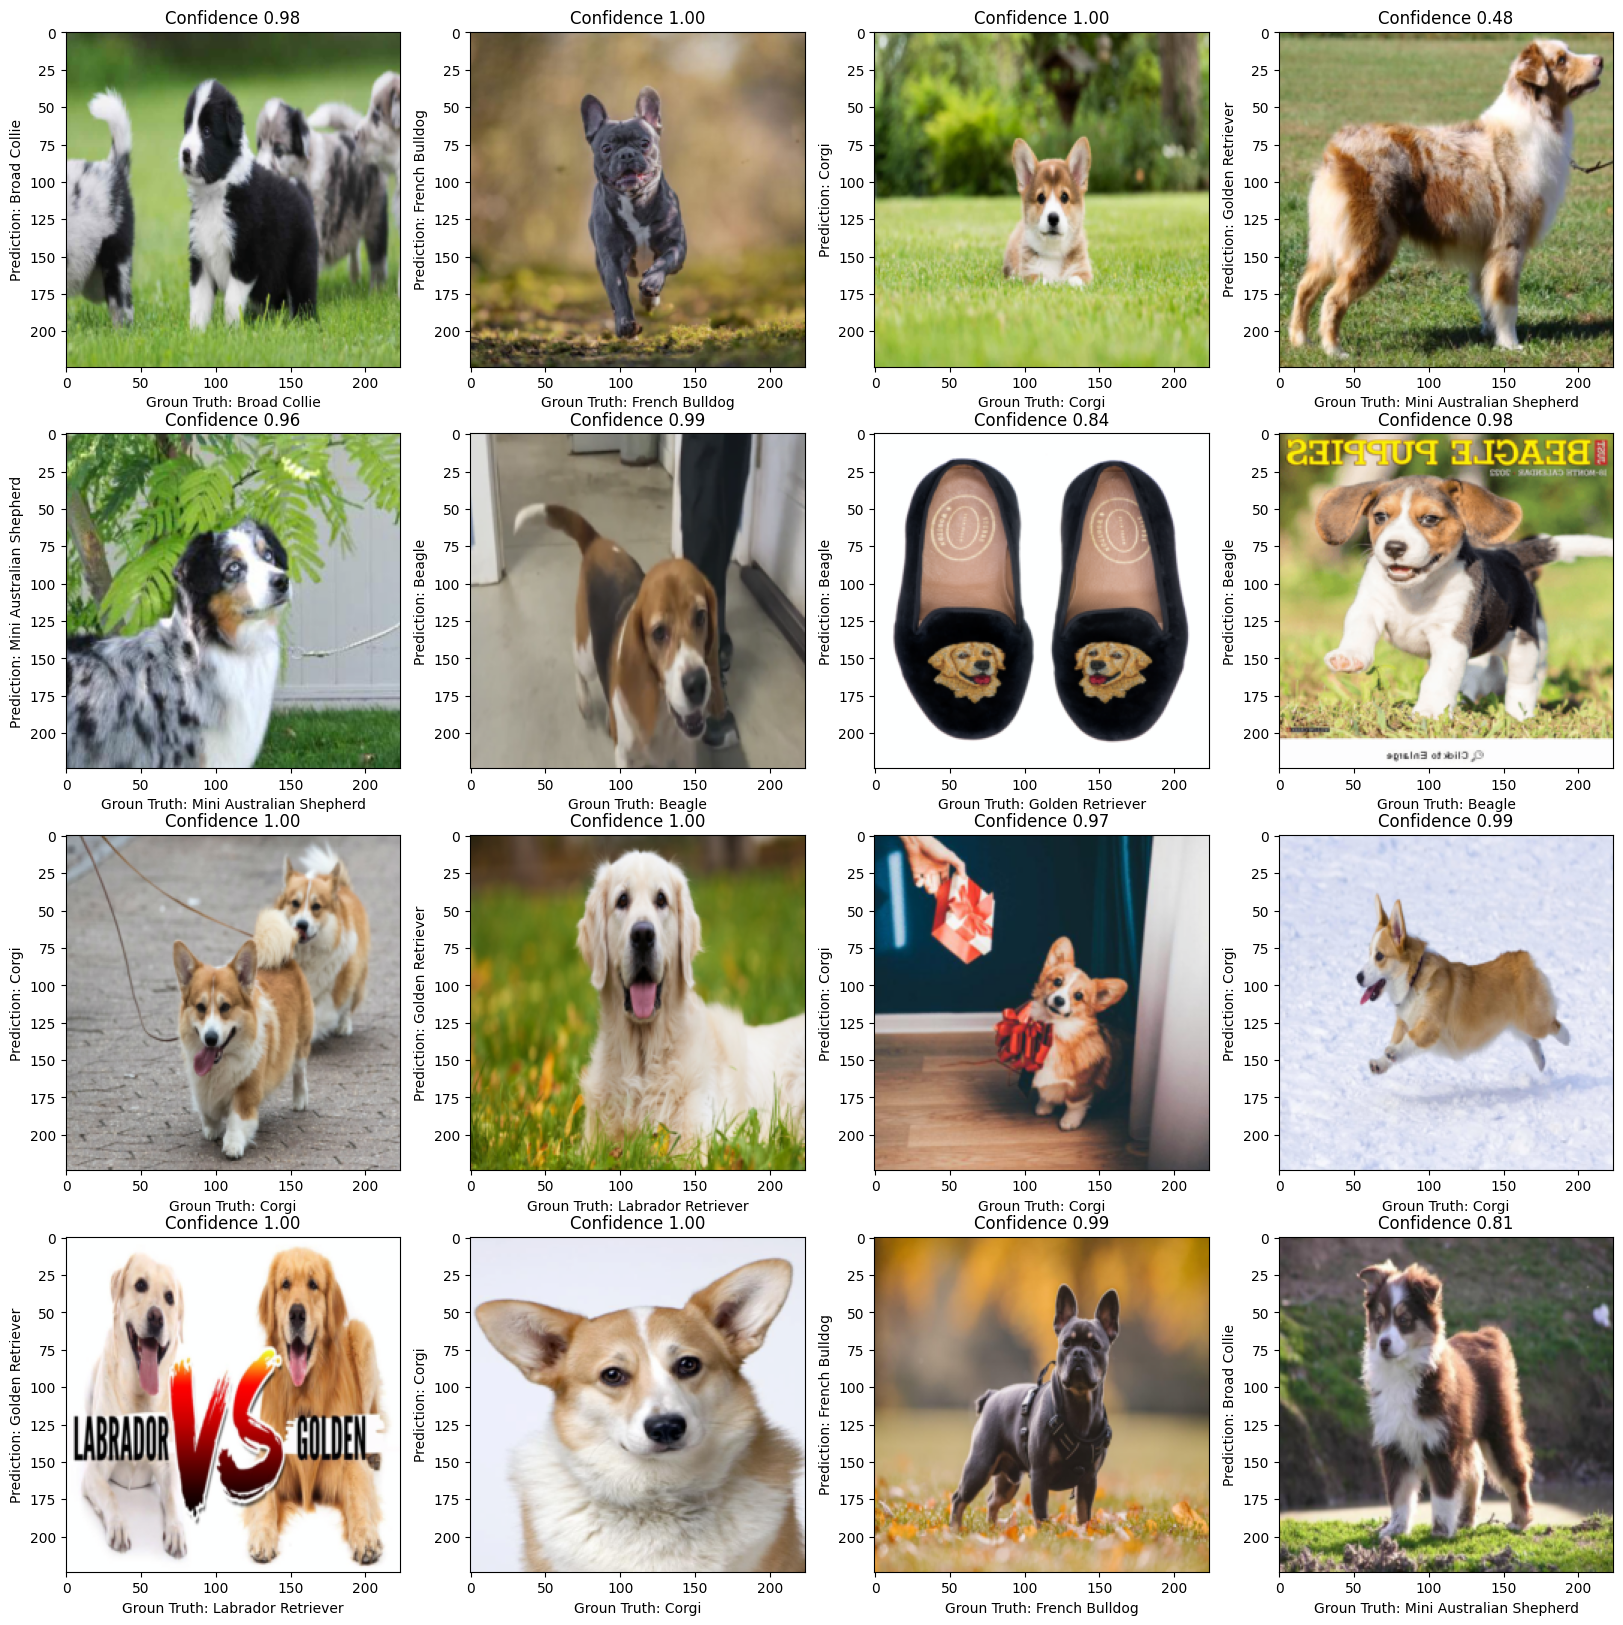

In [118]:
visualize_model(model)

This training is improved and the model shows better rersults in visualization. More importantly, the confidences are high for the true positive cases. We can see that transfer learning is very helpful when we have limited data.

We can save the best model on the validation set. You can download this file to your local machine if you want to study it or transfer learn more. A good example is to try this on your own pet and get a model only recognize it. This is similar to the phone face unlock technique which you can unlock you house dog door for only your pet.  

In [ ]:
torch.save(best_model_weights, 'best_model.pth')

## Output Format

We have learned this. For multi-class classification tasks, the output format is often a vector or matrix containing probabilities for each class in the dataset. Each element of the vector or matrix represents the probability of the input belonging to a particular class. The sum of probabilities across all classes will be equal to 1. The model predicts the class with the highest probability as the final classification.

FileNotFoundError: ignored

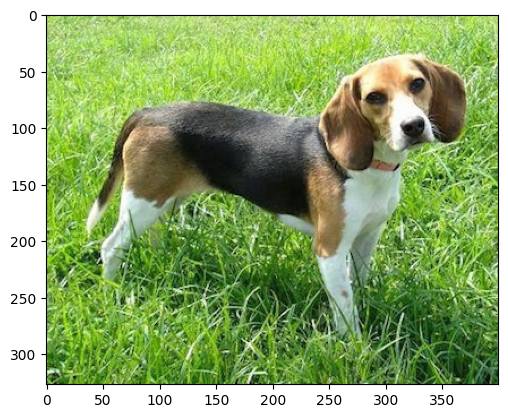

In [ ]:
from PIL import Image

image = Image.open('downloads/Beagle/18.beaglebayleepurebreddogs8months1.jpg')
plt.imshow(image)

resize = transforms.functional.resize(image, size=(224,224))
x = transforms.functional.to_tensor(resize)
x=x.to(device).unsqueeze(0)

with torch.no_grad():
    model.eval()
    out = model_apply(x)
    _, preds = torch.max(out, 1)

print('This is a {}'.format(search_queries[preds]))
sm = torch.nn.Softmax()
confidences = np.array(sm(out.cpu()))
df = pd.DataFrame({'Confidences':confidences[0]},index=search_queries)
df.plot.bar()


In [ ]:
confidences

array([[9.9983966e-01, 2.0265739e-05, 3.8462058e-05, 2.4386703e-05,
        2.1553686e-05, 4.0564988e-05, 1.5000561e-05]], dtype=float32)

In [ ]:
class_namesss = [
'Beagle',
'Golden Retriever',
'Mini Australian Shepherd',
'Broad Collie',
'Corgi',
'Labrador Retriever',
'French Bulldog'
]

['Beagle',
 'Golden Retriever',
 'Mini Australian Shepherd',
 'Broad Collie',
 'Corgi',
 'Labrador Retriever',
 'French Bulldog']

In [119]:
class_names

['Beagle',
 'Broad Collie',
 'Corgi',
 'French Bulldog',
 'Golden Retriever',
 'Labrador Retriever',
 'Mini Australian Shepherd']

## Confusion Matrix Result Analysis

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[10.,  4.,  0.,  3.,  1.,  0.,  2.],
        [ 5., 11.,  0.,  3.,  0.,  0.,  1.],
        [14.,  1.,  0.,  5.,  2.,  0.,  3.],
        [ 4.,  6.,  0.,  2.,  1.,  0.,  3.],
        [ 7.,  1.,  0.,  1.,  4.,  0.,  1.],
        [ 7.,  4.,  0.,  3.,  0.,  0.,  4.],
        [14.,  1.,  0.,  3.,  0.,  0.,  2.]])


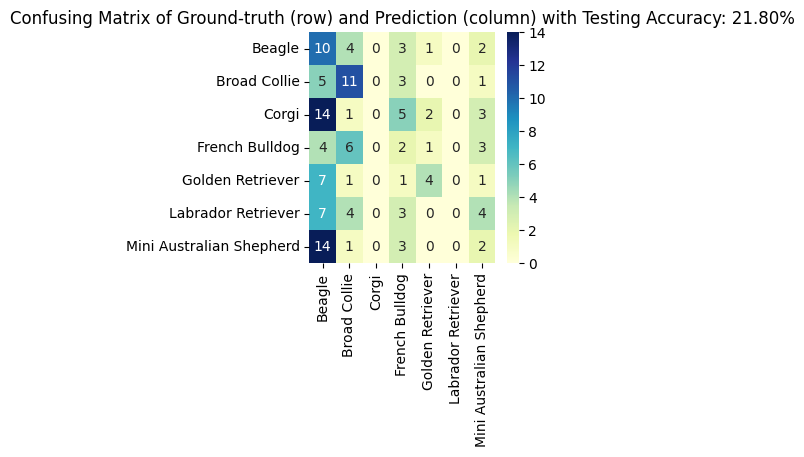

In [ ]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))
df_cm.to_csv(model_name+'.csv')
plt.figure(figsize = (len(class_names)//2,len(class_names)//2))
plt.title('Confusing Matrix of Ground-truth (row) and Prediction (column) with Testing Accuracy: {:0.2f}%'.format(test_acc*100))
plt.xlabel('true label')
plt.ylabel('predicted label')

sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
# plt.savefig(model_name+'Confusing Matrix.png')

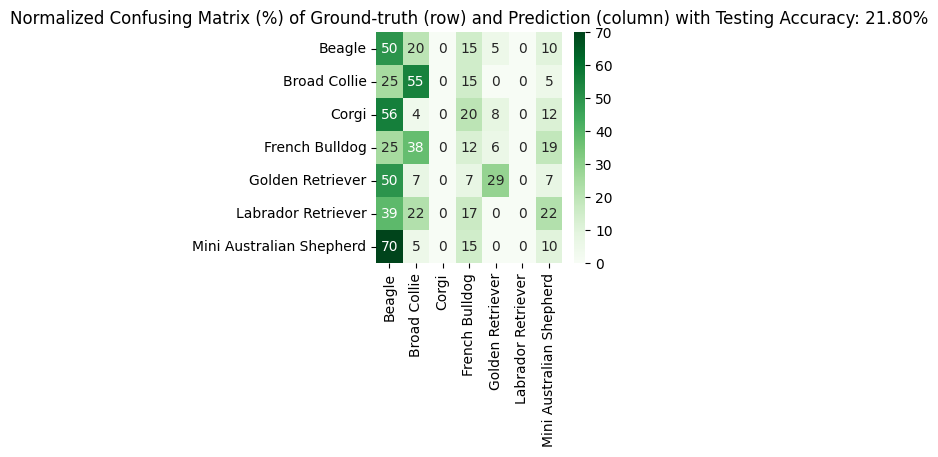

In [ ]:
nor = df_cm / np.array([df_cm.sum(axis=1)]*len(class_names)).transpose()

plt.figure(figsize = (len(class_names)//2,len(class_names)//2))
plt.title('Normalized Confusing Matrix (%) of Ground-truth (row) and Prediction (column) with Testing Accuracy: {:0.2f}%'.format(test_acc*100))

plt.xlabel('true label')
plt.ylabel('predicted label');

sn.heatmap(nor*100, annot=True,fmt='.0f',cmap="Greens")
# plt.savefig(model_name+'Confusing Matrix(%).png')

## Conclustion

In this lab on Transfer Learning, we explored the concept and benefits of leveraging pre-trained models for related tasks. Transfer learning involves reusing a model trained on one task or domain and adapting it to another, avoiding the need to train a new model from scratch. We focused on using the PyTorch framework and loaded the ResNet-18 model with pre-trained weights. By fine-tuning this pre-trained model, we trained it to classify different dog breeds. The training process was compared between using pre-trained weights and starting from scratch.

The results clearly demonstrated the advantage of transfer learning, especially when dealing with limited labeled data. The model trained with pre-trained weights achieved better performance, higher confidence levels in predictions, and showed improved results during visualization. The confidence bar graphs also provided insights into the model's confidence in its predictions.